# Airline Review Analysis - In Progress


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import random
import unicodedata
import re

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from tqdm.notebook import tqdm
from wordcloud import WordCloud

## Data Gathering

Initially, I thought of scrapping the [skytrax](vhttps://www.airlinequality.com/) website, which seemed pretty easy. Before doing that however, a quick search showed me that someone has already done that and the [data uploaded on Kaggle](https://www.kaggle.com/efehandanisman/skytrax-airline-reviews) is fairly recent. 
  
Actually, the fact that it does not include reviews of the last months may be a good thing. As I was browsing skytrax I noticed many recent negative reviews of cancellations, new no-refund policies and lockdown measures, that were caused by Covid-19. Hopefully, this does not reflect the reality of air traveling and we avoid using it in our analysis.  
  
The data is in .xlsx (excel) form. I have avoided converting the file on a .csv so as everyone can download the data from the above Kaggle link and play with the notebook with out having to convert. 

In [2]:
# We drop the aircraft column since it has many NaN values and is not important for our analysis
df = pd.read_excel('datasets/capstone_airline_reviews3.xlsx').drop(['aircraft'], axis=1)

# Many fields will remain empty, but depending on our use case we will accordingly deal with them
df = df.dropna(how='all')

In [3]:
display(df)

,airline,overall,author,review_date,customer_review,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
5,Turkish Airlines,3.0,M Galerko,7th May 2019,âœ… Trip Verified | Rome to Prishtina via Ista...,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,no
7,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,âœ… Trip Verified | Flew on Turkish Airlines I...,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,yes
9,Turkish Airlines,1.0,Pooja Jain,6th May 2019,âœ… Trip Verified | Mumbai to Dublin via Istan...,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131886,Ukraine International,NaN,Yevheniy Kahanovych,21st January 2007,Two domestic flights between Kiev and Lviv las...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131888,Ukraine International,NaN,Helen Lee,15th December 2006,I had a good flight from London to Kiev with U...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131890,Ukraine International,NaN,Andriy Yesypenko,19th May 2006,Kiev - London (Gatwick) in business class (in ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131892,Ukraine International,NaN,Volodya Bilotkach,29th April 2006,Several flights - KBP to AMS (3 times one way)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no


This is a first read for our dataset and we have a lot of cleaning up to do. Depending on what data we need for our analysis we must deal with the remaining `NaN` values.  
Also on the `customer_review` field we can see some unicode characters that must be dealt with.

## Most Important Rating

Each review has a number of ratings:
* Food & Beverages
* Inflight Entertainment
* Seat Comfort
* Value For Money
* Cabin Staff Service
* Ground Service

THe ratings have a value from 1 (being the worst) to 5 (being the best). I would like to find which one of the ratings is the most correlated with **if he would recommend the flight**.  
  
Why I consider the *recommend* value as the best reflection of passenger satisfaction?
If a passenger recommends an airline then this means two things. Firstly, that he would promote to a friend/family the airline. Secondly, in future air traveling is probable that hew would again choose the same airline if possible. From a business perspective I believe this makes the *recommend* metric important.  

### Missing Values

As expected many of the reviews have missing values. The quick approach is to drop all the rows with missing values on the columns we need. We will do that and check how many rows we lose.

In [4]:
# Select the columns we need from the df
rate_importance_df = df.iloc[:,-7:].copy()

# We drop the rows that have a NaN value on the recommended column
rate_importance_df = rate_importance_df[rate_importance_df['recommended'].notna()]

print(f"Rows including NaNs: {len(rate_importance_df)}")

rate_importance_df = rate_importance_df.dropna()

print(f"Rows without NaNs: {len(rate_importance_df)}")

Rows including NaNs: 64440
Rows without NaNs: 24596


We lose about 40.000 rows but we still have ~25.000 rows. At least initially I feel that the remaining rows are enough and no other strategy is followed.

### Correlation

We will now calculate the correlation of each rating with if the *recommendation* value.  
  
Our results will not have a simple interpretation, meaning we must take into account that [**correlation does not imply causation**](https://www.tylervigen.com/spurious-correlations).  
  
**Hypothetical scenario:**  
Let's say we found a great correlation (r >0.9) between recommend and inflight entertainment. One might suggest we should make our flights more entertaining, so we install TVs, music, etc. but after some months we do not have the expected increase on ratings.  
With further analysis we discover that the duration of the flight is highly correlated with the inflight entertainment and consequently with the recommend value.  
This means that long haul flights make the passengers more easily bored and tired and we cannot actually do much about this specific issue since [airplanes will not get much faster](https://aviation.stackexchange.com/a/31386).

In [5]:
# Change the yes/no values on recommend column to 1/0
rate_importance_df.recommended = rate_importance_df.recommended.map(dict(yes=1, no=0))

In our case we have a continuous value for the ratings and a binary value (yes/no) for the recommend value. So, we will use the [point-biserial correlation coefficient](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) which is a [special case of Pearson correlation](https://stats.stackexchange.com/a/105553).  
  
Firstly, I will plot some boxplots which will be a pretty good indication if there is any correlation, before quantifying it.

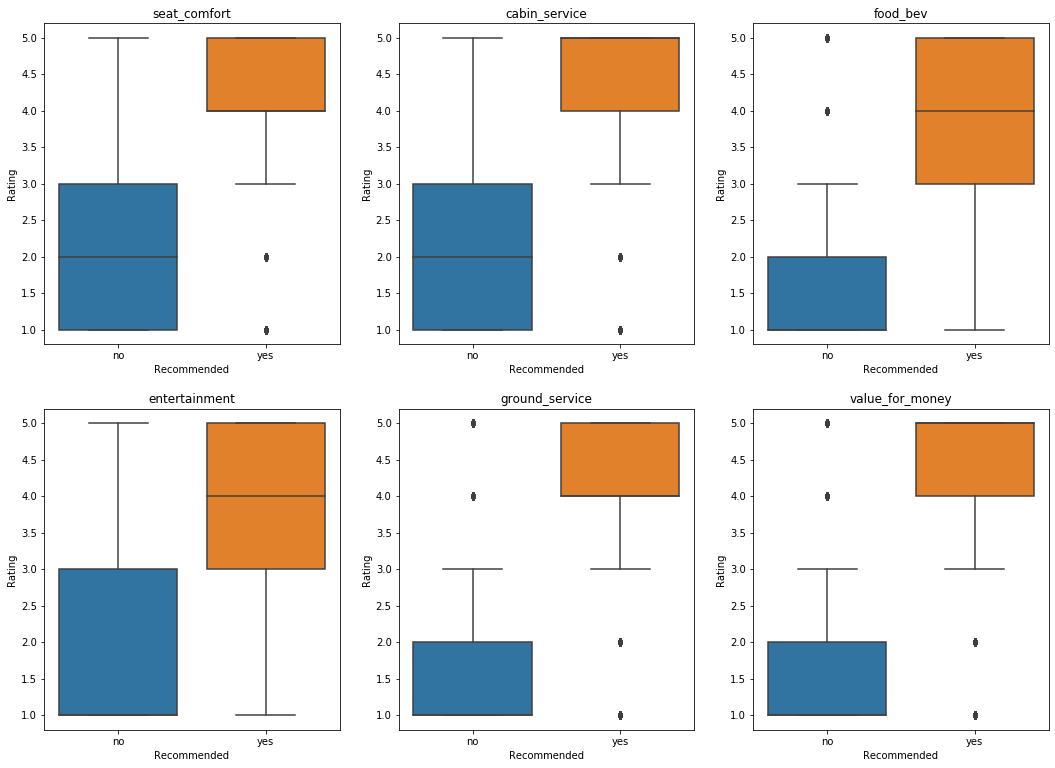

In [6]:
fig = plt.figure(figsize=(18, 13))
plot_index = 1

# Iterate on all the ratings
for which_rating in rate_importance_df.columns[:-1]:
    ax = fig.add_subplot(2, 3, plot_index)
    yes_ratings = np.array(rate_importance_df.loc[rate_importance_df['recommended'] == 1][which_rating])
    no_ratings = np.array(rate_importance_df.loc[rate_importance_df['recommended'] == 0][which_rating])

    ax = sns.boxplot(data=[no_ratings, yes_ratings])
    plt.xticks(range(0, 2), ["no", "yes"])
    plt.title(which_rating)
    plt.ylabel("Rating")
    plt.xlabel("Recommended")
    plot_index += 1

plt.show()


On the above plots we can see that all the ratings are correlated. A low rating on any of these, means a "no" on recommendation and vice versa.  
An observation is, that when we are rating **we are biased from our overall experience**. That means if for example the ground_service is bad this might affect our whole view of the flight negatively and be biased when rating the cabin_service etc.  
This can be shown by calculating the correlations between ratings. This shows **correlation "chains"** which do not allow us to be able to distinguish which one is the most important rating.

In [7]:
# Let's calculate the correlation
for which_rating in rate_importance_df.columns[:-1]:
    r, p = stats.pointbiserialr(rate_importance_df.recommended, rate_importance_df[which_rating])
    print(f"{which_rating},\tr = {np.round(r, decimals=3)} with p-value={p}")

seat_comfort,	r = 0.727 with p-value=0.0
cabin_service,	r = 0.745 with p-value=0.0
food_bev,	r = 0.738 with p-value=0.0
entertainment,	r = 0.652 with p-value=0.0
ground_service,	r = 0.751 with p-value=0.0
value_for_money,	r = 0.838 with p-value=0.0


As we can see most of them have the same levels of r-coefficients with entertainment being a bit lower and value for money a bit higher (which is expected since value for money can be considered as a summarizing rating of all the other ratings).  
  
**So by simply looking at the ratings I believe we cannot have a decisive answer on what the airlines should improve.**

## Review Text Processing

Since the above analysis does not have a clear results we will now try to have insights from the text of the reviews. This sounds more helpful, because although the ratings are biased from the overall experience the text should be focused on more specific events.

In [8]:
# Again we will not use all the columns of the df
reviews_df = df[['customer_review', 'recommended']].copy()
reviews_df = reviews_df.dropna()

### Cleaning the Reviews

The reviews as expected contain a lot of non ascii characters. We will review how many of them there are and decide if we should delete them or encode them on ascii.

In [9]:
# Find how many reviews have non-ascii characters
mask_nonAscii = reviews_df['customer_review'].str.len()\
                 .ne(reviews_df['customer_review'].str.encode('ascii',errors = 'ignore').str.len())
print(f'Reviews with non ascii characters: {sum(mask_nonAscii)} out of {len(reviews_df)}')

Reviews with non ascii characters: 28238 out of 64440


Since 28238 is a big number of reviews we will see if we can avoid deleting them. For this reason I will print some random reviews.

In [10]:
for i in range(3):
    rev = reviews_df[mask_nonAscii].iloc[random.sample(range(0, len(reviews_df[mask_nonAscii])), 1)[0]].customer_review
    print(f'{rev}\n\n')

âœ… Trip Verified | Tokyo Narita to Helsinki Vantaa on 4 Aug with AY72 and back on 12 Aug with AY71. On both legs I got into Business Class. Before booking them, I was quite surprised to know that Finnair has two daily services between NRT and HEL. My expectations for the flights mounted up, as I thought that they would offer in-flight services favorable to Japanese people. They belied me. Too frugal and sometimes stingy. They might say, â€œWe think green, or we think of the protection of limited resources on earth. Thus we adopt the policy â€˜No reading materials on board.â€™â€ I had never experienced Business Class with no newspaper available. They also say that some reading materials are available on web. Wi-fi is free for downloading the first one. The problem is that the selections are limited. Besides, on the outbound flight from NRT in-flight wi-fi was out of order. They contacted me on this matter one day before departing. No alternative solution was offered on the boarding da

After some prints of the reviews that have non-ascii characters we notice some things:
* The non-ascii characters are the first three "âœ"
* Most of the reviews have at the start "Trip Verified |" and then the trip departing and arriving location  
  
We first deal with two above and then count again the non-ascii reviews.

In [11]:
# Split on the first '.' and keep the second part, CARE: This cannot be executed two consecutive times
reviews_df['customer_review'] = reviews_df['customer_review'] .map(
    lambda x: x.split('.', 1)[1] if len(x.split('.', 1)) > 1 
    else None
)


# Drop 26 rows taht ended up not having anythong after their first '.'
reviews_df = reviews_df.dropna()

# Let's again count the non-ascii reviews
mask_nonAscii = reviews_df['customer_review'].str.len()\
                 .ne(reviews_df['customer_review'].str.encode('ascii',errors = 'ignore').str.len())
print(f'Reviews with non ascii characters: {sum(mask_nonAscii)} out of {len(reviews_df)}')

Reviews with non ascii characters: 6458 out of 64414


In [12]:
for i in range(3):
    rev = reviews_df[mask_nonAscii].iloc[random.sample(range(0, len(reviews_df[mask_nonAscii])), 1)[0]].customer_review
    print(f'{rev}\n\n')

 I donâ€™t fly the airline nearly as much now that we have moved to Hilton Head Island, since connections from Savannah are not in general as good as for other airlines to the destinations to which we fly. Recently my wife and I took a cruise from Barcelona to Lisbon on Oceania Cruise lines on which, as part of the package, they booked us on AA for outbound flights from Savannah to Philadelphia to Barcelona. As soon as I knew our flights, I went online to select seats, and the only ones we could get were the two center seats of the middle section (seat configuration 2-4-2). As my wife really likes window seats for transatlantic flights, I attempted to change seats at the check-in desk in Philadelphia. We were then able to get the G and H (side aisle and window) seats in row 35, the last economy row aft in the airplane. That is usually fine with us - quiet and a little more room. We flew those seats on Qantas for 14 hours to New Zealand. I sat in the aisle seat. I am 5â€™6â€ tall, 148 

After again printing some non-ascii reviews we notice that in most cases it is caused by **the apostrophe of [contractions](https://dictionary.cambridge.org/grammar/british-grammar/contractions) (didn't, haven't, etc) not being the ASCII apostrophe**. Since these words do not have a significant meaning that differentiates a positive from a negative review I believe we are allowed to just encode the strings on ASCII.

In [13]:
# Decode all the non-ascii characters from the reviews
reviews_df['customer_review'] = reviews_df['customer_review'].apply(lambda x: x.encode('ascii', 'ignore').\
                                                              strip())

# Go from bytes object to strings
reviews_df['customer_review'] = reviews_df['customer_review'].str.decode("utf-8")

# Final check that there no non-ascii characters in all the reviews
mask_nonAscii = reviews_df['customer_review'].str.len()\
                 .ne(reviews_df['customer_review'].str.encode('ascii',errors = 'ignore').str.len())
print(f'Reviews with non ascii characters: {sum(mask_nonAscii)} out of {len(reviews_df)}')

Reviews with non ascii characters: 0 out of 64414


### Text Normalization

Now we reach the point that we want to see which words seem to be mostly used by the travelers in their reviews. Of course, words like "and", "have", etc will have a big frequency. Using a stopwords dictionary we will remove all of these words that do not offer us any information.

In [29]:
def normalize_review(review):
    """
    We will lower case all the words, remove punctuation, remove stopwords and lemmatize the verbs
    
    Args:
        review (str): The original review (in ascii)
        
    Returns:
        str: The normalized review
    """
    words = nltk.word_tokenize(review)
    
    # Lower words
    lower_words = [word.lower() for word in words]
    
    # Remove punctuation
    words_no_punctuation = []
    for word in lower_words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            words_no_punctuation.append(new_word)
    
    # Remove stopwords
    words_no_stopwords = []
    for word in words_no_punctuation:
        if word not in stopwords.words('english'):
            words_no_stopwords.append(word)
    
    # Lemmatize the verbs (eg ran -> run)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words_no_punctuation]
            
    return " ".join(lemmatized_words)

**Warning**: The below cell takes **16 minutes** in my laptop. In case you want to run the cells below you could first slice the `reviews_df` and select rows, like:
```python
# Random sample of 5000 rows
reviews_df = reviews_df.sample(n=5000)
```

In [30]:
tqdm.pandas()

# Normalize all the reviews
reviews_df['customer_review'] = reviews_df['customer_review'].progress_apply(lambda x : normalize_review(x))

display(reviews_df)

,customer_review,recommended
1,first time id fly tk i find them very good in ...,yes
3,we make our check in in the airport they take ...,no
5,i fly with this company several time in the pa...,no
7,turkish airlines have consistently maintain it...,yes
9,never book turkish airlines if you be travel t...,no
...,...,...
131886,manual checkin swift plan old 737 but clean an...,no
131888,check in be very fast much quicker than my exp...,no
131890,have fly with uia so many time i be expect tha...,no
131892,mix experience have be yell at once try to cor...,no


### Wordclouds

One quick way to visualize words with high frequencies is to use wordclouds. We will create one for the `recommended="yes"` and one for the `recommended="no"`. 

In [41]:
recomended_yes_text = " ".join(review for review 
                               in reviews_df.loc[reviews_df['recommended'] == "yes"].customer_review)

recomended_no_text = " ".join(review for review 
                               in reviews_df.loc[reviews_df['recommended'] == "no"].customer_review)

wordcloud_yes = WordCloud(background_color="white").generate(recomended_yes_text)
wordcloud_no = WordCloud(background_color="white").generate(recomended_no_text)

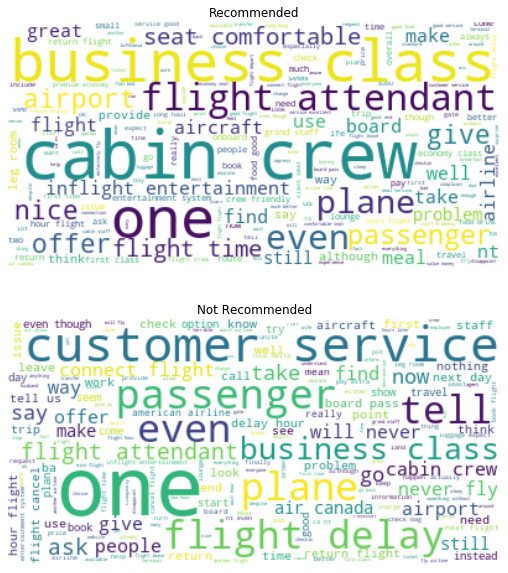

In [42]:
fig = plt.figure(figsize=(18, 10))

ax = fig.add_subplot(2, 1, 1)
plt.title("Recommended")
plt.imshow(wordcloud_yes, interpolation='bilinear')
plt.axis("off")


ax = fig.add_subplot(2, 1, 2)
plt.title("Not Recommended")
plt.imshow(wordcloud_no, interpolation='bilinear')
plt.axis("off")

plt.show()

Observing the not recommended wordcloud we can easily see some expected words like:
* flight delay
* customer sercive
* connect flight
  
However, we must "quantify" the observations of this wordcloud using other techniques.  
  
Before doing that I was curious to find out why word "one" had such a high frequency on both recommended and not recommended reviews.  
The cell below prints reviews containing "one" and we can see that it is just a commonly used word that has no significant meaning in the traveling reviews.

In [51]:
reviews_df_no = reviews_df.loc[reviews_df['recommended'] == "no"].copy()
contains_one = reviews_df_no[reviews_df_no['customer_review'].str.contains("one")]

# Print 2 random reviews containing the word "one"
for i in range(2):
    print(f'{contains_passenger.iloc[random.sample(range(0, len(contains_passenger)), 1)[0]].customer_review}\n\n')

flight be pack with kid obviously the sales pitch of the norland train nanny work though i do nt see much evidence of them be around there be a lot of screamingsquealing all through the flight seat allocation be a nightmare be sure to get online as soon as you can and book your seat do not leave it until you get to the airport or you ll end up wedge in the middle of a middle section i ve fly a lot on many different airlines and i find the seat in this one incredibly tight and uncomfortable so much so that i wake up in the middle of the night once i get home because my back be so sore the food be pretty ordinary in the middle of a 14hr leg to sydney we get a cold bread roll with three thin slice of tomato on it i have never be so hungry on a plane the final service before land be rush with the staff basically toss the food at us from pile in their arm there be only one choice and half the content of my tray be miss but the staff be so stretch i do nt bother to harass them about it the 3